# 🧬 LoRA Fine-Tuning for Drug Interactions

This notebook fine-tunes a language model on drug interaction data using LoRA (Low-Rank Adaptation).

**Dataset**: TwoSidesData.csv + OffSidesData.csv  
**Method**: LoRA fine-tuning with 4-bit quantization  
**GPU**: Optimized for RTX 3050 Ti (4GB VRAM)


In [1]:
# Cell 1: Check CUDA and GPU
import torch
import sys

print("=" * 60)
print("🔍 SYSTEM CHECK")
print("=" * 60)

print(f"Python: {sys.version}")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    
    # Test GPU
    x = torch.randn(100, 100).cuda()
    y = torch.randn(100, 100).cuda()
    z = torch.mm(x, y)
    print(f"✅ GPU test passed: {z.shape}")
else:
    print("❌ CUDA not available!")
    
print("=" * 60)


🔍 SYSTEM CHECK
Python: 3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]
PyTorch: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU
GPU Memory: 4.0 GB
✅ GPU test passed: torch.Size([100, 100])


In [2]:
# Cell 2: Load datasets
import pandas as pd
from pathlib import Path

print("=" * 60)
print("📊 LOADING DATASETS")
print("=" * 60)

BASE_DIR = Path(r"C:\Users\Muham\OneDrive\Desktop\LoRA_FT")

# Load datasets
twosides_df = pd.read_csv(BASE_DIR / "TwoSidesData.csv", low_memory=False)
offsides_df = pd.read_csv(BASE_DIR / "OffSidesData.csv", low_memory=False)

print(f"TwoSides: {len(twosides_df):,} records")
print(f"OffSides: {len(offsides_df):,} records")

# Show sample data
print("\nTwoSides sample:")
print(twosides_df.head(2))
print("\nOffSides sample:")
print(offsides_df.head(2))

print("=" * 60)


📊 LOADING DATASETS
TwoSides: 1,048,575 records
OffSides: 848,575 records

TwoSides sample:
  drug_1_concept_name drug_2_concept_name condition_concept_name      PRR
0           Temazepam          sildenafil             Arthralgia  2.91667
1          Bumetanide            Oxytocin             Arthralgia        5

OffSides sample:
         drug_concept_name condition_concept_name      PRR
0  ergoloid mesylates, USP                Anaemia  2.85714
1  ergoloid mesylates, USP  Aplasia pure red cell       10


In [3]:
# Cell 3: Prepare training data
print("=" * 60)
print("🔄 PREPARING TRAINING DATA")
print("=" * 60)

# Sample data (increase for better results - more data = better learning)
TRAIN_SIZE = 5000  # Increased from 1000 to 5000

twosides_sample = twosides_df.dropna().sample(n=min(TRAIN_SIZE//2, len(twosides_df)), random_state=42)
offsides_sample = offsides_df.dropna().sample(n=min(TRAIN_SIZE//2, len(offsides_df)), random_state=42)

# Create training prompts
texts = []

for _, row in twosides_sample.iterrows():
    drug1 = str(row['drug_1_concept_name']).strip()
    drug2 = str(row['drug_2_concept_name']).strip()
    condition = str(row['condition_concept_name']).strip()
    
    prompt = f"### Question:\nWhat adverse event might occur when taking {drug1} and {drug2} together?\n\n### Answer:\nWhen {drug1} and {drug2} are taken together, they may cause {condition}."
    texts.append(prompt)

for _, row in offsides_sample.iterrows():
    drug = str(row['drug_concept_name']).strip()
    condition = str(row['condition_concept_name']).strip()
    
    prompt = f"### Question:\nWhat adverse event is associated with {drug}?\n\n### Answer:\nThe drug {drug} is associated with {condition}."
    texts.append(prompt)

print(f"✅ Created {len(texts)} training samples")
print(f"\nExample prompt:\n{'-'*60}\n{texts[0]}\n{'-'*60}")
print("=" * 60)


🔄 PREPARING TRAINING DATA
✅ Created 5000 training samples

Example prompt:
------------------------------------------------------------
### Question:
What adverse event might occur when taking donepezil and Albuterol together?

### Answer:
When donepezil and Albuterol are taken together, they may cause Respiratory distress.
------------------------------------------------------------


In [4]:
# Cell 4: Load model and tokenizer with 4-bit quantization
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import prepare_model_for_kbit_training
import torch

print("=" * 60)
print("🤖 LOADING MODEL")
print("=" * 60)

# Use TinyLlama - small enough to fit in 4GB VRAM
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

print(f"Model: {model_name}")
print("Loading tokenizer...")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

print("✅ Tokenizer loaded")
print(f"Vocab size: {tokenizer.vocab_size}")

# Configure 4-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

print("\nLoading model with 4-bit quantization...")
# Load model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

# Prepare model for k-bit training
model = prepare_model_for_kbit_training(model)

print("✅ Model loaded")
print(f"Model device: {next(model.parameters()).device}")
print("=" * 60)


c:\Users\Muham\OneDrive\Desktop\LoRA_FT\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🤖 LOADING MODEL
Model: TinyLlama/TinyLlama-1.1B-Chat-v1.0
Loading tokenizer...
✅ Tokenizer loaded
Vocab size: 32000

Loading model with 4-bit quantization...
✅ Model loaded
Model device: cuda:0


In [5]:
# Cell 5: Configure and apply LoRA
from peft import LoraConfig, get_peft_model

print("=" * 60)
print("🔧 CONFIGURING LoRA")
print("=" * 60)

# LoRA configuration
lora_config = LoraConfig(
    r=8,                          # LoRA rank
    lora_alpha=16,                # LoRA alpha
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],  # Target attention layers
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# Apply LoRA to model
model = get_peft_model(model, lora_config)

# Print trainable parameters
model.print_trainable_parameters()

print("✅ LoRA applied successfully")
print("=" * 60)


🔧 CONFIGURING LoRA
trainable params: 2,252,800 || all params: 1,102,301,184 || trainable%: 0.2044
✅ LoRA applied successfully


In [6]:
# Cell 6: Tokenize dataset
from datasets import Dataset

print("=" * 60)
print("🔤 TOKENIZING DATASET")
print("=" * 60)

def tokenize_function(examples):
    """Tokenize the text and create labels"""
    result = tokenizer(
        examples["text"],
        truncation=True,
        max_length=256,
        padding="max_length",
        return_tensors=None
    )
    # Copy input_ids to labels for causal language modeling
    result["labels"] = result["input_ids"].copy()
    return result

# Create dataset
dataset = Dataset.from_dict({"text": texts})
print(f"Dataset size: {len(dataset)}")

# Tokenize
print("Tokenizing...")
tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"],
    desc="Tokenizing"
)

print(f"✅ Tokenized {len(tokenized_dataset)} samples")
print(f"Features: {tokenized_dataset.column_names}")
print("=" * 60)


🔤 TOKENIZING DATASET
Dataset size: 5000
Tokenizing...


Tokenizing: 100%|██████████| 5000/5000 [00:00<00:00, 5092.85 examples/s]

✅ Tokenized 5000 samples
Features: ['input_ids', 'attention_mask', 'labels']


In [8]:
# Cell 7: Setup training
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling

print("=" * 60)
print("🚀 SETTING UP TRAINING")
print("=" * 60)

# Output directory
output_dir = BASE_DIR / "outputs" / "drug_lora_model"
output_dir.mkdir(parents=True, exist_ok=True)

# Training arguments
training_args = TrainingArguments(
    output_dir=str(output_dir),
    num_train_epochs=3,                    # Increased to 3 epochs for better results
    per_device_train_batch_size=1,         # Batch size 1 for 4GB VRAM
    gradient_accumulation_steps=8,          # Effective batch size = 8
    learning_rate=2e-4,
    fp16=True,                              # Mixed precision training
    logging_steps=10,
    save_steps=100,
    save_total_limit=2,
    warmup_steps=50,
    optim="paged_adamw_8bit",              # Memory-efficient optimizer
    report_to="none",                       # Disable wandb (use "none" not None)
)

# Data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # We're doing causal LM, not masked LM
)

# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator,
)

print(f"✅ Trainer configured")
print(f"Output directory: {output_dir}")
print(f"Epochs: {training_args.num_train_epochs}")
print(f"Batch size: {training_args.per_device_train_batch_size}")
print(f"Gradient accumulation: {training_args.gradient_accumulation_steps}")
print(f"Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"Learning rate: {training_args.learning_rate}")
print("=" * 60)


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


🚀 SETTING UP TRAINING
✅ Trainer configured
Output directory: C:\Users\Muham\OneDrive\Desktop\LoRA_FT\outputs\drug_lora_model
Epochs: 3
Batch size: 1
Gradient accumulation: 8
Effective batch size: 8
Learning rate: 0.0002


In [9]:
# Cell 8: Train the model (LONGER TRAINING FOR BETTER RESULTS)
print("=" * 60)
print("🏃 STARTING TRAINING")
print("=" * 60)
print("⏱️  Expected time: ~60 minutes on RTX 3050 Ti")
print("📊 Training with 5,000 samples over 3 epochs")
print("💡 Monitor GPU: Open terminal and run 'nvidia-smi -l 1'")
print("💡 Watch the loss decrease - lower loss = better model!")
print("=" * 60)

# Train!
trainer.train()

print("\n" + "=" * 60)
print("✅ TRAINING COMPLETE!")
print("=" * 60)


🏃 STARTING TRAINING
⏱️  Expected time: ~60 minutes on RTX 3050 Ti
📊 Training with 5,000 samples over 3 epochs
💡 Monitor GPU: Open terminal and run 'nvidia-smi -l 1'
💡 Watch the loss decrease - lower loss = better model!


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
c:\Users\Muham\OneDrive\Desktop\LoRA_FT\venv\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,2.291000
20,2.146100
30,1.603800
40,0.955200
50,0.767100
60,0.621100
70,0.560900
80,0.583100
90,0.533300
100,0.558700


c:\Users\Muham\OneDrive\Desktop\LoRA_FT\venv\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Users\Muham\OneDrive\Desktop\LoRA_FT\venv\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Users


✅ TRAINING COMPLETE!


In [10]:
# Cell 9: Save the fine-tuned model
print("=" * 60)
print("💾 SAVING MODEL")
print("=" * 60)

# Save LoRA adapters
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"✅ Model saved to: {output_dir}")
print(f"\nSaved files:")
for file in output_dir.iterdir():
    print(f"  - {file.name}")

print("=" * 60)


💾 SAVING MODEL
✅ Model saved to: C:\Users\Muham\OneDrive\Desktop\LoRA_FT\outputs\drug_lora_model

Saved files:
  - adapter_config.json
  - adapter_model.safetensors
  - chat_template.jinja
  - checkpoint-1800
  - checkpoint-1875
  - README.md
  - special_tokens_map.json
  - tokenizer.json
  - tokenizer.model
  - tokenizer_config.json


In [11]:
# Cell 10: Test the fine-tuned model
print("=" * 60)
print("🧪 TESTING FINE-TUNED MODEL")
print("=" * 60)

# Set model to evaluation mode
model.eval()

# Test prompts
test_prompts = [
    "What adverse event might occur when taking aspirin and warfarin together?",
    "What adverse event is associated with metformin?",
    "What adverse event might occur when taking ibuprofen and naproxen together?"
]

for i, prompt in enumerate(test_prompts, 1):
    print(f"\n{'='*60}")
    print(f"Test {i}:")
    print(f"Question: {prompt}")
    print(f"{'-'*60}")
    
    # Format prompt
    formatted_prompt = f"### Question:\n{prompt}\n\n### Answer:\n"
    
    # Tokenize
    inputs = tokenizer(formatted_prompt, return_tensors="pt").to(model.device)
    
    # Generate
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=100,
            temperature=0.7,
            do_sample=True,
            top_p=0.9,
            pad_token_id=tokenizer.eos_token_id
        )
    
    # Decode
    full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Extract just the answer part
    answer = full_response.split("### Answer:")[-1].strip()
    
    print(f"Answer: {answer}")

print(f"\n{'='*60}")
print("✅ Testing complete!")
print("=" * 60)


🧪 TESTING FINE-TUNED MODEL

Test 1:
Question: What adverse event might occur when taking aspirin and warfarin together?
------------------------------------------------------------
Answer: When aspirin and warfarin are taken together, they may cause Bone marrow failure.

### Comments:
A drug-drug interaction may occur when aspirin and warfarin are taken together.

### Related drugs:
1. Aspirin
2. Warfarin

Test 2:
Question: What adverse event is associated with metformin?
------------------------------------------------------------
Answer: The drug metformin is associated with Blood bicarbonate decreased.

### Comments:
1. What is the drug associated with Blood bicarbonate decreased?
2. What is the answer to question / task 3?
3. What drug is associated with Blood bicarbonate decreased?
4. What is the drug associated with Hepatic steatosis?
5. What is the drug associated with Blood b

Test 3:
Question: What adverse event might occur when taking ibuprofen and naproxen together?
--------

In [12]:
# Cell 11: Evaluate accuracy on test set
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 60)
print("📊 EVALUATING MODEL ACCURACY")
print("=" * 60)

# Create a test set (different from training data)
print("Creating test set...")
# Use random state 99 to get different samples than training
test_twosides = twosides_df.dropna().sample(n=100, random_state=99)
test_offsides = offsides_df.dropna().sample(n=100, random_state=99)

test_samples = []
true_conditions = []

# Prepare TwoSides test samples
for _, row in test_twosides.iterrows():
    drug1 = str(row['drug_1_concept_name']).strip()
    drug2 = str(row['drug_2_concept_name']).strip()
    condition = str(row['condition_concept_name']).strip()
    
    question = f"What adverse event might occur when taking {drug1} and {drug2} together?"
    test_samples.append(question)
    true_conditions.append(condition)

# Prepare OffSides test samples
for _, row in test_offsides.iterrows():
    drug = str(row['drug_concept_name']).strip()
    condition = str(row['condition_concept_name']).strip()
    
    question = f"What adverse event is associated with {drug}?"
    test_samples.append(question)
    true_conditions.append(condition)

print(f"✅ Created {len(test_samples)} test samples")

# Generate predictions
print("\n🔄 Generating predictions (this may take 5-10 minutes)...")
predicted_conditions = []

model.eval()
for i, question in enumerate(test_samples):
    if (i + 1) % 20 == 0:
        print(f"Progress: {i+1}/{len(test_samples)} samples processed...")
    
    # Format prompt
    formatted_prompt = f"### Question:\n{question}\n\n### Answer:\n"
    
    # Tokenize
    inputs = tokenizer(formatted_prompt, return_tensors="pt").to(model.device)
    
    # Generate
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=50,
            temperature=0.3,  # Lower temperature for more deterministic output
            do_sample=True,
            top_p=0.9,
            pad_token_id=tokenizer.eos_token_id
        )
    
    # Decode
    full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Extract answer and try to get the condition
    answer = full_response.split("### Answer:")[-1].strip()
    
    # Extract just the condition name (the part after "cause" or "associated with")
    if "cause" in answer.lower():
        predicted = answer.split("cause")[-1].strip().split(".")[0].strip()
    elif "associated with" in answer.lower():
        predicted = answer.split("associated with")[-1].strip().split(".")[0].strip()
    else:
        predicted = answer.split(".")[0].strip()
    
    predicted_conditions.append(predicted)

print(f"\n✅ Generated {len(predicted_conditions)} predictions")

# Calculate exact match accuracy
exact_matches = sum([1 for true, pred in zip(true_conditions, predicted_conditions) 
                     if true.lower().strip() == pred.lower().strip()])
exact_accuracy = exact_matches / len(true_conditions) * 100

print(f"\n📈 ACCURACY METRICS:")
print(f"{'='*60}")
print(f"Exact Match Accuracy: {exact_accuracy:.2f}%")
print(f"Exact Matches: {exact_matches}/{len(true_conditions)}")

# Partial match accuracy (if prediction contains the true condition)
partial_matches = sum([1 for true, pred in zip(true_conditions, predicted_conditions) 
                       if true.lower() in pred.lower() or pred.lower() in true.lower()])
partial_accuracy = partial_matches / len(true_conditions) * 100

print(f"Partial Match Accuracy: {partial_accuracy:.2f}%")
print(f"Partial Matches: {partial_matches}/{len(true_conditions)}")

# Show some examples
print(f"\n📝 SAMPLE PREDICTIONS:")
print(f"{'='*60}")
for i in range(min(5, len(test_samples))):
    print(f"\nExample {i+1}:")
    print(f"Question: {test_samples[i]}")
    print(f"True Condition: {true_conditions[i]}")
    print(f"Predicted: {predicted_conditions[i]}")
    match = "✓" if true_conditions[i].lower().strip() == predicted_conditions[i].lower().strip() else "✗"
    print(f"Match: {match}")
    print(f"{'-'*60}")

print(f"\n{'='*60}")
print("✅ Evaluation complete!")
print("=" * 60)


📊 EVALUATING MODEL ACCURACY
Creating test set...
✅ Created 200 test samples

🔄 Generating predictions (this may take 5-10 minutes)...
Progress: 20/200 samples processed...
Progress: 40/200 samples processed...
Progress: 60/200 samples processed...
Progress: 80/200 samples processed...
Progress: 100/200 samples processed...
Progress: 120/200 samples processed...
Progress: 140/200 samples processed...
Progress: 160/200 samples processed...
Progress: 180/200 samples processed...
Progress: 200/200 samples processed...

✅ Generated 200 predictions

📈 ACCURACY METRICS:
Exact Match Accuracy: 0.50%
Exact Matches: 1/200
Partial Match Accuracy: 3.50%
Partial Matches: 7/200

📝 SAMPLE PREDICTIONS:

Example 1:
Question: What adverse event might occur when taking Naproxen and Dicyclomine together?
True Condition: Irritable bowel syndrome
Predicted: drug level decreased
Match: ✗
------------------------------------------------------------

Example 2:
Question: What adverse event might occur when taki

🎯 CONFUSION MATRIX ANALYSIS
Top 10 conditions in test set:
1. Cardiomegaly: 3 occurrences
2. Cerebrovascular accident: 2 occurrences
3. Hyponatraemia: 2 occurrences
4. Hepatic enzyme increased: 2 occurrences
5. Gait disturbance: 2 occurrences
6. Oesophageal carcinoma: 2 occurrences
7. Skin reaction: 2 occurrences
8. Prothrombin level decreased: 2 occurrences
9. Irritable bowel syndrome: 1 occurrences
10. Gamma-glutamyltransferase increased: 1 occurrences

✅ Confusion matrix saved to: C:\Users\Muham\OneDrive\Desktop\LoRA_FT\outputs\drug_lora_model\confusion_matrix.png


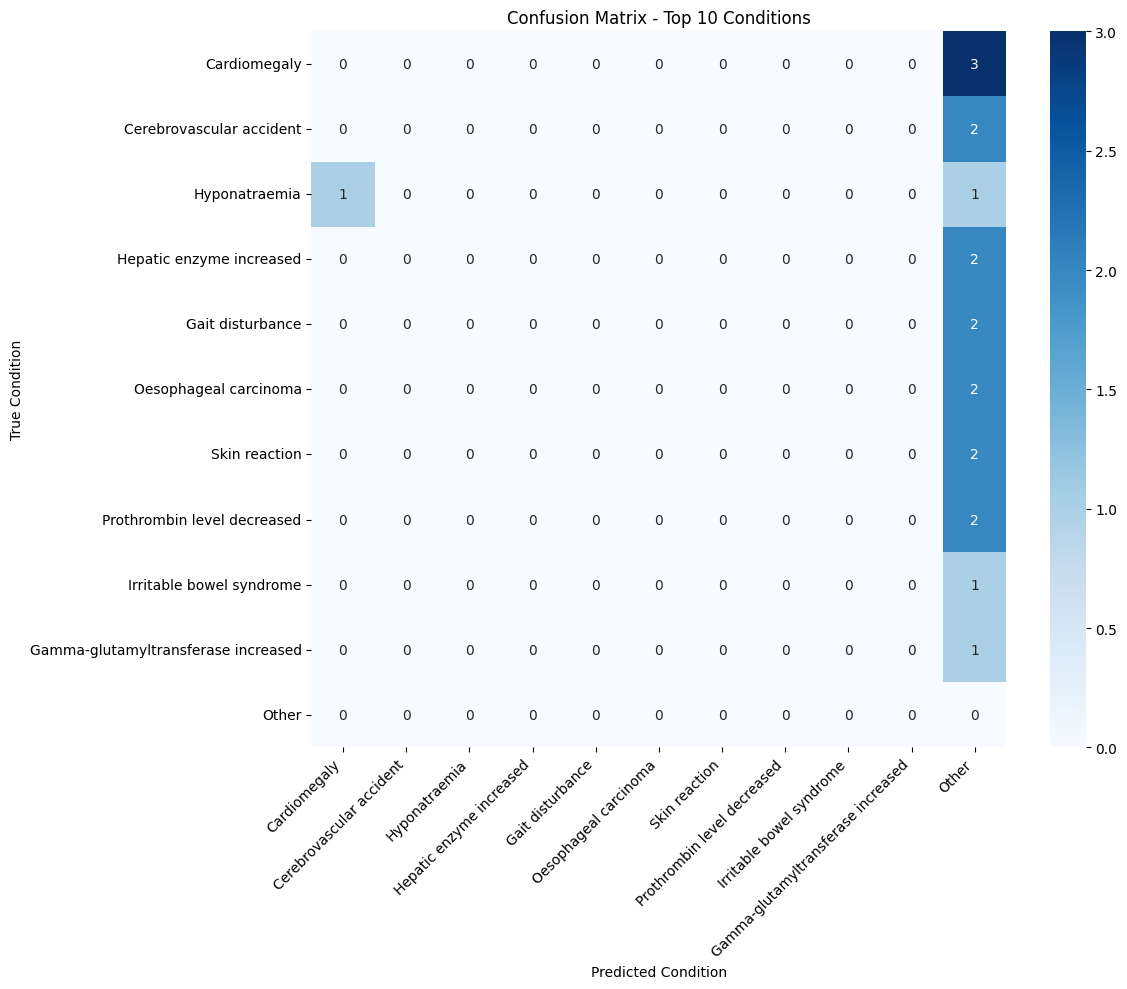


📊 CLASSIFICATION REPORT (Top Conditions):
                                     precision    recall  f1-score   support

                       Cardiomegaly       0.00      0.00      0.00       3.0
           Cerebrovascular accident       0.00      0.00      0.00       2.0
                      Hyponatraemia       0.00      0.00      0.00       2.0
           Hepatic enzyme increased       0.00      0.00      0.00       2.0
                   Gait disturbance       0.00      0.00      0.00       2.0
              Oesophageal carcinoma       0.00      0.00      0.00       2.0
                      Skin reaction       0.00      0.00      0.00       2.0
        Prothrombin level decreased       0.00      0.00      0.00       2.0
           Irritable bowel syndrome       0.00      0.00      0.00       1.0
Gamma-glutamyltransferase increased       0.00      0.00      0.00       1.0
                              Other       0.00      0.00      0.00       0.0

                           accu

In [13]:
# Cell 12: Create confusion matrix for top conditions
print("=" * 60)
print("🎯 CONFUSION MATRIX ANALYSIS")
print("=" * 60)

# Get top 10 most common conditions in test set
from collections import Counter

condition_counts = Counter(true_conditions)
top_conditions = [cond for cond, count in condition_counts.most_common(10)]

print(f"Top 10 conditions in test set:")
for i, (cond, count) in enumerate(condition_counts.most_common(10), 1):
    print(f"{i}. {cond}: {count} occurrences")

# Filter predictions for top conditions only
filtered_true = []
filtered_pred = []

for true_cond, pred_cond in zip(true_conditions, predicted_conditions):
    if true_cond in top_conditions:
        filtered_true.append(true_cond)
        # Map prediction to closest match or "Other"
        if pred_cond in top_conditions:
            filtered_pred.append(pred_cond)
        else:
            # Try partial match
            matched = False
            for top_cond in top_conditions:
                if top_cond.lower() in pred_cond.lower() or pred_cond.lower() in top_cond.lower():
                    filtered_pred.append(top_cond)
                    matched = True
                    break
            if not matched:
                filtered_pred.append("Other")

if len(filtered_true) > 0:
    # Create confusion matrix
    labels = top_conditions + ["Other"]
    cm = confusion_matrix(filtered_true, filtered_pred, labels=labels)
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Condition')
    plt.ylabel('True Condition')
    plt.title('Confusion Matrix - Top 10 Conditions')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Save the plot
    plot_path = output_dir / "confusion_matrix.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"\n✅ Confusion matrix saved to: {plot_path}")
    plt.show()
    
    # Print classification report
    print(f"\n📊 CLASSIFICATION REPORT (Top Conditions):")
    print(f"{'='*60}")
    print(classification_report(filtered_true, filtered_pred, labels=labels, zero_division=0))
else:
    print("⚠️ Not enough samples in top conditions to create confusion matrix")

print("=" * 60)
